In [1]:
%pylab inline
import matplotlib as mpl
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


In [2]:
S_PER_HOUR = 3600
MM_PER_M = 1000

In [3]:
ds1 = xr.open_dataset('./output/syntheticHillslope-exp1_output_timestep.nc')
ds2 = xr.open_dataset('./output/syntheticHillslope-exp2_output_timestep.nc')

In [4]:
np.argwhere(ds1['pptrate'].sum(dim='hru').values == 0)[0][0]

550

In [5]:
def drainable_water(ds):
    soil_slice = slice(0, int(ds['nSoil'].values[0]))
    return (ds['mLayerDepth'].isel(midToto=soil_slice) 
            * (ds['mLayerVolFracLiq'].isel(midToto=soil_slice) 
               - ds['fieldCapacity'])).sum(dim='midToto')

In [6]:
TOPMODEL_exp1 = 1.0
surfHydCond1 = 0.3

TOPMODEL_exp2 = 3.0
surfHydCond2 = 3.0

tan_slope = 0.3
soilDepth = 1.5
porosity = 0.25
qRain = 0.002

totalLength = 50.
hillWidth = 100.
domain_area = hillWidth * totalLength

hill_dist = np.arange(1, 1+len(ds1.hru))
kinematic_dist = np.linspace(0, totalLength, num=1000)

In [7]:
def kinematic_storage(surfHydCond, soilDepth, TOPMODEL_exp, porosity, qrain, itime, hill_dist):
    t0 = surfHydCond * soilDepth / TOPMODEL_exp
    x1 = t0 * tan_slope / qRain
    x2 = itime * qRain / (porosity * soilDepth)
    xL = min(x1 * x2 ** TOPMODEL_exp, hill_dist[-1])
    
    hS = soilDepth * ((qRain * hill_dist) / (t0 * tan_slope)) ** (1./TOPMODEL_exp)
    hL = soilDepth * ((qRain * xL) / (t0 * tan_slope)) ** (1./TOPMODEL_exp)
    hS[hS>hL] = hL
    return hS

In [8]:
def kinematic_runoff(surfHydCond, soilDepth, TOPMODEL_exp, porosity, domain_area, hillWidth, hill_dist, qRain):
    t0 = surfHydCond * soilDepth / TOPMODEL_exp
    hS = soilDepth * (qRain[0] * hill_dist / (t0 * tan_slope)) ** (1/TOPMODEL_exp)
    qKin = np.ones_like(qRain) * -9999
    for i, q in enumerate(qRain):
        if q > 0:
            tc = i+1
            x1 = t0 * tan_slope / q
            x2 = tc * q / (porosity * soilDepth)
            xL = min(x1*x2 ** TOPMODEL_exp, hill_dist[-1])
            hL = soilDepth * (q * xL / (t0 * tan_slope)) ** (1/TOPMODEL_exp)
            qKin[i] = (1/domain_area) * hillWidth * tan_slope * t0 * ((hL / soilDepth) ** TOPMODEL_exp)
    
    dtdz = (tan_slope * t0 / soilDepth) * TOPMODEL_exp * (hS / soilDepth) ** (TOPMODEL_exp - 1)
    dxdt = dtdz / porosity
    td = 550.
    delX = totalLength - hill_dist
    tExit = td + delX / dxdt
    qFall = (1/domain_area) * hillWidth * tan_slope * t0 * ((hS/soilDepth) ** TOPMODEL_exp)
    qKin = qKin[qKin > 0]
    return qKin, qFall, tExit

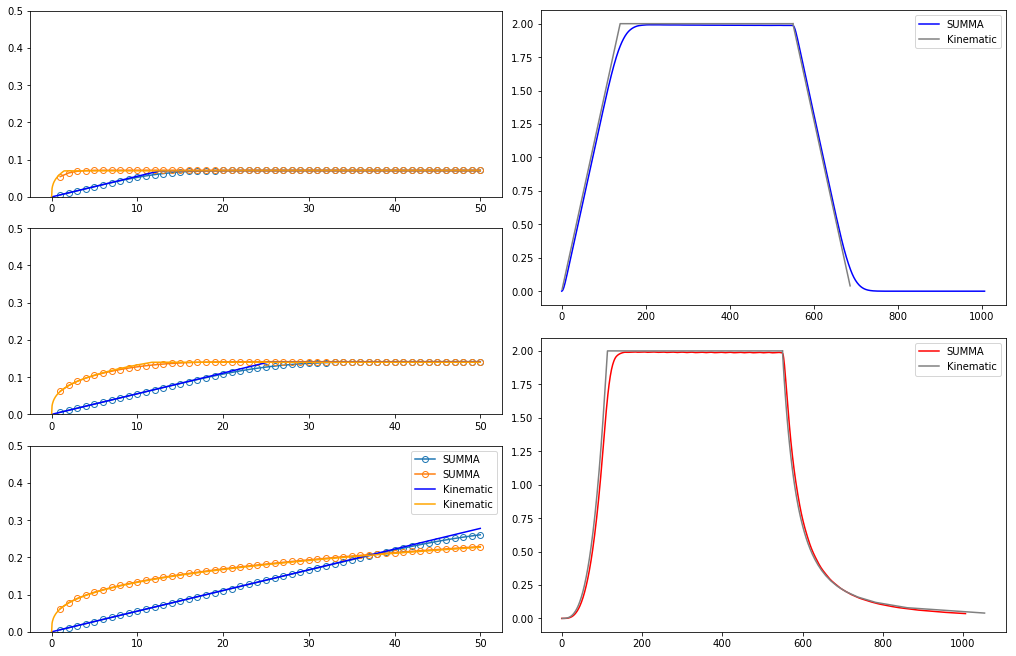

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(14, 9))
gs = fig.add_gridspec(1, 2)
gs0 = gs[0].subgridspec(3, 1)
gs1 = gs[1].subgridspec(2, 1)

for a in range(3):
    fig.add_subplot(gs0[a, 0])
for b in range(2):
    fig.add_subplot(gs1[b, 0])
    
axes = fig.axes

itime=35
axes[0].set_ylim([0, 0.5])
axes[0].plot(hill_dist, drainable_water(ds1.isel(time=itime)), marker='o', markerfacecolor='None')
axes[0].plot(hill_dist, drainable_water(ds2.isel(time=itime)), marker='o', markerfacecolor='None')

hS1 = kinematic_storage(surfHydCond1, soilDepth, TOPMODEL_exp1, porosity, qRain, itime, kinematic_dist)
hS2 = kinematic_storage(surfHydCond2, soilDepth, TOPMODEL_exp2, porosity, qRain, itime, kinematic_dist)
axes[0].plot(kinematic_dist, porosity * hS1, color='blue')
axes[0].plot(kinematic_dist, porosity * hS2, color='orange')

itime = 70
axes[1].set_ylim([0, 0.5])
axes[1].plot(hill_dist, drainable_water(ds1.isel(time=itime)), marker='o', markerfacecolor='None')
axes[1].plot(hill_dist, drainable_water(ds2.isel(time=itime)), marker='o', markerfacecolor='None')

hS1 = kinematic_storage(surfHydCond1, soilDepth, TOPMODEL_exp1, porosity, qRain, itime, kinematic_dist)
hS2 = kinematic_storage(surfHydCond2, soilDepth, TOPMODEL_exp2, porosity, qRain, itime, kinematic_dist)
axes[1].plot(kinematic_dist, porosity * hS1, color='blue')
axes[1].plot(kinematic_dist, porosity * hS2, color='orange')


itime = 140
axes[2].set_ylim([0, 0.5])
axes[2].plot(hill_dist, drainable_water(ds1.isel(time=itime)), marker='o', markerfacecolor='None', label='SUMMA')
axes[2].plot(hill_dist, drainable_water(ds2.isel(time=itime)), marker='o', markerfacecolor='None', label='SUMMA')

hS1 = kinematic_storage(surfHydCond1, soilDepth, TOPMODEL_exp1, porosity, qRain, itime, kinematic_dist)
hS2 = kinematic_storage(surfHydCond2, soilDepth, TOPMODEL_exp2, porosity, qRain, itime, kinematic_dist)
axes[2].plot(kinematic_dist, porosity * hS1, label='Kinematic', color='blue')
axes[2].plot(kinematic_dist, porosity * hS2, label='Kinematic', color='orange')
axes[2].legend()


qKin1, qFall1, texit1 = kinematic_runoff(surfHydCond1, soilDepth, TOPMODEL_exp1, porosity, domain_area, 
                                         hillWidth, hill_dist,  (ds1['pptrate'].isel(hru=0) * 3600 / 1000).values)
axes[3].plot(np.arange(0, len(ds1.time)), MM_PER_M * S_PER_HOUR * ds1['averageRoutedRunoff'], color='blue', label='SUMMA')
axes[3].plot(np.arange(1, 1+len(qKin1)), MM_PER_M * qKin1, color='grey', label='Kinematic')
axes[3].plot(texit1, MM_PER_M * qFall1, color='grey')
axes[3].legend()

qKin2, qFall2, texit2 = kinematic_runoff(surfHydCond2, soilDepth, TOPMODEL_exp2, porosity, domain_area, 
                                         hillWidth, hill_dist,  (ds1['pptrate'].isel(hru=0) * 3600 / 1000).values)
axes[4].plot(np.arange(0, len(ds2.time)), MM_PER_M * S_PER_HOUR * ds2['averageRoutedRunoff'], color='red', label='SUMMA')
axes[4].plot(np.arange(1, 1+len(qKin2)), MM_PER_M * qKin2, color='grey', label='Kinematic')
axes[4].plot(texit2, MM_PER_M * qFall2, color='grey')
axes[4].legend()

plt.savefig('./img/lt4_wigmosta.png')